# Effect of look-ahead distance

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import math
from pathlib import Path
import os
from collections import defaultdict
import analysis_lib as al
import matplotlib.ticker as ticker  # 追加


path_list = ["PathA", "PathB", "PathC"]
controller_list = ["PP", "APP", "RPP", "DWPP"]
PathA, PathB, PathC = al.make_path()
reference_path = {
    "PathA": PathA,
    "PathB": PathB,
    "PathC": PathC
}
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'stix'   # ← 重要
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'


In [55]:
def calc_tracking_error_and_travel_time(df: pd.DataFrame):
    # Extract relevant data
    timestamp = df["sec"].to_numpy() + df["nsec"].to_numpy() * 1e-9
    timestamp -= timestamp[0]  # Normalize to start from zero
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()
    
    # calc RMSE
    path = reference_path["PathC"]
    robot_path = np.vstack((x, y)).T
    tracking_errors = al.calc_tracking_error(robot_path, path)
    mean_tracking_error = np.mean(tracking_errors)
    max_tracking_error = np.max(tracking_errors)
    
    # calc travel time
    travel_time = al.measure_travel_time(timestamp)
    return mean_tracking_error, max_tracking_error, travel_time
    

In [56]:
data_026_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/lookahead/segment_026.csv")
data_039_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/lookahead/segment_039.csv")
data_052_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/lookahead/segment_052.csv")
data_065_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/lookahead/segment_065.csv")
data_078_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/lookahead/segment_078.csv")
data_091_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/lookahead/segment_091.csv")
data_104_path = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/lookahead/segment_104.csv")

data_026_df = pd.read_csv(data_026_path)
data_039_df = pd.read_csv(data_039_path)
data_052_df = pd.read_csv(data_052_path)
data_065_df = pd.read_csv(data_065_path)
data_078_df = pd.read_csv(data_078_path)
data_091_df = pd.read_csv(data_091_path)
data_104_df = pd.read_csv(data_104_path)

df_list = [data_026_df, data_039_df, data_052_df, data_065_df, data_078_df, data_091_df, data_104_df]
lookahead_values = [0.26, 0.39, 0.52, 0.65, 0.78, 0.91, 1.04]
mean_tracking_errors = []
max_tracking_errors = []
linear_velocities = []
timestamps = []
travel_times = []
for df in df_list:
    mean_error, max_error, travel_time = calc_tracking_error_and_travel_time(df)
    mean_tracking_errors.append(mean_error)
    max_tracking_errors.append(max_error)
    travel_times.append(travel_time)
    
    v = df["v_real"].to_numpy()
    linear_velocities.append(v)
    timestamp = df["sec"].to_numpy() + df["nsec"].to_numpy() * 1e-9
    timestamp -= timestamp[0]  # Normalize to start from zero
    timestamps.append(timestamp)

Plot

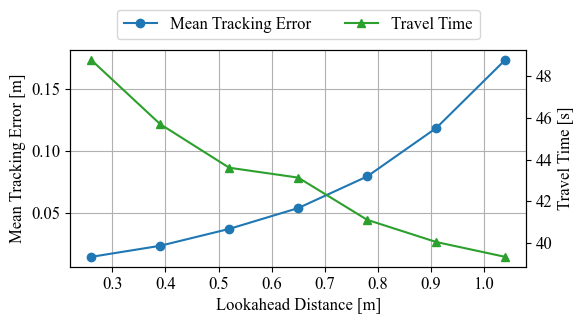

In [57]:
fig = plt.figure(figsize=(6, 3))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(lookahead_values, mean_tracking_errors, marker='o', label='Mean Tracking Error', color='C0')
# ax1.plot(lookahead_values, max_tracking_errors, marker='s', label='Max Tracking Error', color='C1')
ax1.set_xlabel('Lookahead Distance [m]')
ax1.set_ylabel('Mean Tracking Error [m]')
ax1.grid(True)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(lookahead_values, travel_times, marker='^', label='Travel Time', color='C2')
ax2.set_ylabel('Travel Time [s]')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.tight_layout()
ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='lower center',           # 凡例自身の基準点
           bbox_to_anchor=(0.5, 1.05),    # グラフ枠に対する相対位置 (x, y)
           ncol=2,                       # 2列に並べる
           borderaxespad=0, 
           frameon=True)
filepath = "/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/lookahead/lookahead_vs_performance.pdf"
plt.savefig(filepath, dpi=300, bbox_inches='tight')


In [66]:

def plot_path(csv_paths: list[Path], path_name: str, controller_names: list[str]):
    # ... (データ読み込み部分は変更なし) ...
    paths = []
    for csv_path in csv_paths:
        df = pd.read_csv(csv_path)
        data_dir = csv_path.parent
        x = df["x"].to_numpy()
        y = df["y"].to_numpy()
        path = np.vstack((x, y)).T
        paths.append(path)
    
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(1, 1, 1)
    
    # 1. データの順序を (y, x) に入れ替えてプロット
    # これにより、縦軸が x、横軸が y になります
    for path, lookahead_value in zip(paths, lookahead_values):
        x_vals = path.T[0]
        y_vals = path.T[1]
        ax.plot(y_vals, x_vals, label=f"{lookahead_value}", linewidth=1)
    
    ref_x = [point[0] for point in reference_path[path_name]]
    ref_y = [point[1] for point in reference_path[path_name]]
    ax.plot(ref_y, ref_x, 'k--', label='Reference Path', linewidth=1, alpha=0.7)

    # 2. 目盛りを 1m 間隔に設定
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))

    # 3. ラベルを入れ替え
    ax.set_xlabel('$y$ [m]')
    ax.set_ylabel('$x$ [m]')

    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

    # 4. 横軸（現在の y 軸データ）を反転させて、左方向を正（増加方向）にする
    ax.invert_xaxis()
    
    # 5. 縦軸（現在の x 軸データ）は反転させない（上方向が正になる）
    # 元のコードにあった ax.invert_yaxis() は削除します
    
    plt.tight_layout()
    
    filepath = data_dir / 'path_comparison.pdf'
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

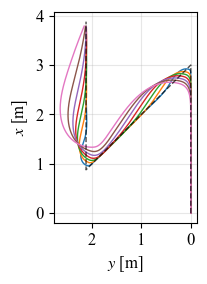

In [67]:
plot_path([data_026_path, data_039_path, data_052_path, data_065_path, data_078_path, data_091_path, data_104_path], "PathC", ["DWPP", "DWPP", "DWPP", "DWPP", "DWPP", "DWPP", "DWPP"])

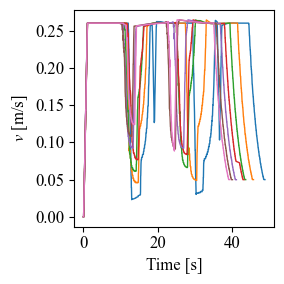

In [60]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1, 1, 1)

for timestamp, linear_velocity, lookahead_value in zip(timestamps, linear_velocities, lookahead_values):
    ax.plot(timestamp, linear_velocity, label=f"{lookahead_value}", linewidth=1)

# --- 前述のプロット処理 ---
# ax1 (経路) や ax2 (速度) からハンドルとラベルを取得
handles, labels = ax.get_legend_handles_labels()

# --- 凡例専用のFigure作成 ---
# figsizeは凡例の横幅に合わせて調整してください
fig_leg = plt.figure(figsize=(8, 0.5)) 
ax_leg = fig_leg.add_subplot(111)

# 凡例を描画 (ncolで横並びの列数を指定)
#  共通のLookahead値とReference Pathが含まれます
leg = ax_leg.legend(handles, labels, loc='center', ncol=8, frameon=True)

# 背景の軸などを完全に消す
ax_leg.axis('off')

# 保存 (bbox_inches='tight' で余白を最小化、pad_inchesで微調整)
legend_path = "legend_only.pdf"
fig_leg.savefig(legend_path, bbox_inches='tight', pad_inches=0.05)
plt.close(fig_leg)

ax.set_xlabel('Time [s]')
ax.set_ylabel('$v$ [m/s]')

plt.tight_layout()
# plt.legend()

filepath = "/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/lookahead/linear_velocities.pdf"

plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.show()
